In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_csv('Kickstarter.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum']
del df["Location"], #df['Month'], df["CDescLength"], df['HasVideo']
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)


y = np.array(df.pop("Success"))
X = pd.get_dummies(df)
headers = X.columns
X = X.values
X = preprocessing.scale(X)
print(X.shape)

(25250, 59)


### Izbira najboljših parametrov

In [5]:
from __future__ import print_function
from sklearn import datasets, cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
_, X_param, _, y_param = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the parameters by cross-validation
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100, 250, 500, 750, 1000]}
rf_params = {'n_estimators': [10, 100, 500, 1000, 2000, 2500, 5000]}
#gbc_params = {'n_estimators': [1, 10, 100, 250, 500, 575, 650, 800, 1000]}
et_params = {'n_estimators': [10, 100, 1000, 2000, 3500, 5000]}


# Logistic Regression
clf_lr = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring="roc_auc")
clf_lr.fit(X_param, y_param)

# Random Forest
clf_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring="roc_auc")
clf_rf.fit(X_param, y_param)

# Extra Trees
clf_et = GridSearchCV(ExtraTreesClassifier(), et_params, cv=5, scoring="roc_auc")
clf_et.fit(X_param, y_param)


print("Best parameters (LR):", clf_lr.best_params_)
print("Best parameters (RF):", clf_rf.best_params_)
print("Best parameters (ET):", clf_et.best_params_)

Best parameters (LR): {'C': 250, 'penalty': 'l1'}
Best parameters (RF): {'n_estimators': 2000}
Best parameters (ET): {'n_estimators': 3000}


In [3]:
df = pd.read_csv('Kickstarter_2016.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum']
del df["Location"]
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)

y_test = np.array(df.pop("Success"))
X_test = pd.get_dummies(df)
del df

for key in headers.difference(X_test.columns):
    X_test[key] = 0
for key in X_test.columns.difference(headers):
    del X_test[key]
X_test = X_test[headers]
X_test = X_test.values
X_test = preprocessing.scale(X_test)

## Vrednotenje uspešnosti modelov
Napovedovanje uspešnosti projektov, ki so nastali po začetku izdelave projektne naloge in vrednotenje rezultatov.

In [14]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

models = {'LR': LogisticRegression(**clf_lr.best_params_),
          'RF': RandomForestClassifier(**clf_rf.best_params_),
          'ET': ExtraTreesClassifier(**clf_et.best_params_)}

    
results = {'LR': {}, 'RF': {}, 'ET': {}}#, 'ET':{}}


for key in models:
    models[key].fit(X, y)

    results[key].setdefault('F1', []) 
    results[key].setdefault('AUC', [])
    results[key].setdefault('CA', [])
    ypred = models[key].predict(X_test)
    ypred_prob = models[key].predict_proba(X_test)[:, 1]

    # F1
    results[key]['F1'].append(metrics.f1_score(y_test, ypred))

    # CA
    results[key]['CA'].append(metrics.accuracy_score(y_test, ypred))
    
    # AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred_prob, pos_label=1)
    results[key]['AUC'].append(metrics.auc(fpr, tpr))

print('\t F1\t     AUC\t CA')
for key in results:
    print(key, "\t", "{:.3f}".format(np.mean(results[key]['F1'])), "     ", 
          "{:.3f}".format(np.mean(results[key]['AUC'])), "     ",
          "{:.3f}".format(np.mean(results[key]['CA'])))

	 F1	     AUC	 CA
RF 	 0.762       0.903       0.769
ET 	 0.810       0.931       0.856
LR 	 0.766       0.901       0.776


## ROC krivulja
Izris ROC krivulje za logistično regresijo, Random Forest in metodo Extra trees.

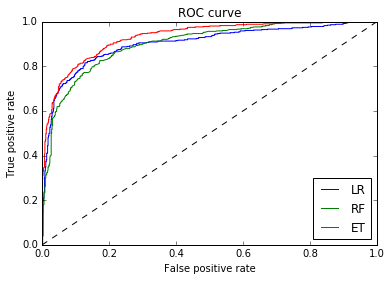

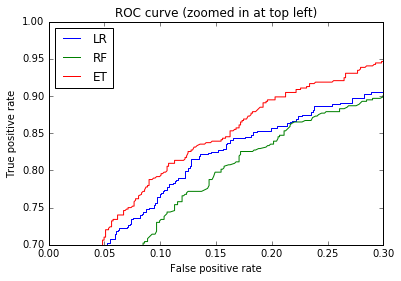

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# The logistic regression model
lr = LogisticRegression(**{'C': 250, 'penalty': 'l1'})
lr.fit(X, y)
y_pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

# Extra trees model
etc = ExtraTreesClassifier(**{'n_estimators': 3000})
etc.fit(X, y)
y_pred_etc = etc.predict_proba(X_test)[:, 1]
fpr_etc, tpr_etc, _ = roc_curve(y_test, y_pred_etc)


# The random forest model
rf = RandomForestClassifier(**{'n_estimators': 2000})
rf.fit(X, y)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
        
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_etc, tpr_etc, label='ET')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_etc, tpr_etc, label='ET')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## Napovedovanje z stackingom
Napovedovanje z metodo stacking, ki jo na prvem nivoju sestavljajo: logistična reg., Random Forest in metoda Extra trees.

In [34]:
import numpy as np
import Orange as org
import Orange
import Orange.regression
import Orange.classification
from Orange.classification import LogisticRegressionLearner
from Orange.classification import Model
from Orange.regression import LinearRegressionLearner
from Orange.evaluation import CrossValidation
from Orange.data import Table, Domain, ContinuousVariable
from sklearn import preprocessing
from sklearn import metrics 

class StackedClassificationLearner(Orange.classification.Learner):

    def __init__(self, learners, meta_learner=LogisticRegressionLearner, k=5):
        super().__init__()
        self.k = k  # number of internal cross-validations
        self.learners = learners
        self.meta_learner = meta_learner  # base learner
        self.name = "stacking"

    def fit_storage(self, data):
        """Return a stacked model inferred from the training set."""
        n = len(data.domain.class_var.values)
        features = [ContinuousVariable("F%d" % i)
                    for i in range(len(self.learners) * (n - 1))]
        domain = Domain(features, data.domain.class_var)
        kf_total = cross_validation.KFold(len(data.X), n_folds=5)
        p_data = y = None
        for train, test in kf_total:
            for learner in self.learners:
                learner.fit(data.X[train], data.Y[train])
            if p_data is None:
                p_data =  np.hstack(learner.predict_proba(data.X[test])[:, :-1] for learner in self.learners)
                y = np.array(data.Y[test])
            else:
                p_data = np.append(p_data, np.hstack(learner.predict_proba(data.X[test])[:, :-1] for learner in self.learners), axis=0)
                y = np.append(y, data.Y[test])
        #print(p_data[:5])
        meta_data = Table(domain, p_data, y)
        meta_model = self.meta_learner(meta_data)
        models = [learner.fit(data.X, data.Y) for learner in self.learners]
        return StackedClassificationModel(data.domain, Domain(features),
                                          models, meta_model, name=self.name)

class StackedClassificationModel(Orange.classification.Model):
    """
    Stacked classifier.
    """
    def __init__(self, domain, meta_domain, models,
                 meta_model, name="stacking"):
        super().__init__(domain)
        self.models = models  # a list of predictors
        self.meta_model = meta_model
        self.meta_domain = meta_domain
        self.name = name

    def predict_storage(self, data):
        """Given a data table returns predicted class."""
        x = np.hstack(model.predict_proba(data.X)[:, :-1] for model in self.models)
        #print("x:", x[:5])
        #print(self.meta_domain, Model.ValueProbs)
        data = Table(self.meta_domain, x)
        return self.meta_model(data, Model.ValueProbs)

In [35]:
import Orange as org
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import svm



data = org.data.Table("attr.csv")
data.X = X
data.Y = y

models = [RandomForestClassifier(**clf_rf.best_params_),
          LogisticRegression(**clf_lr.best_params_),
          ExtraTreesClassifier(**clf_et.best_params_)]

# initialize multi-stage model
scl = StackedClassificationLearner(models)

# fit model
scm = scl.fit_storage(data)

In [36]:
from sklearn import metrics

data.X = X_test
data.Y = y_test
ypred = scm.predict_storage(data)

# F1
result_f1 = metrics.f1_score(y_test, ypred[0])

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred[1][:, 1], pos_label=1)
result_auc = metrics.auc(fpr, tpr)

result_ca = metrics.accuracy_score(y_test, ypred[0])
       
print('\t\t F1\t    AUC     CA')
print("Stacking\t", "{:.3f}".format(result_f1), "     ", 
          "{:.3f}".format(result_auc), "     ", 
          "{:.3f}".format(result_ca))

		 F1	    AUC     CA
Stacking	 0.667       0.811       0.646


### Napake
Metoda Extra trees

In [49]:
models = {'ET': ExtraTreesClassifier(**clf_et.best_params_)}
results = {'ET': {}}
y_pred = []
y_p = []

for key in models:
    models[key].fit(X, y)

    results[key].setdefault('F1', []) 
    results[key].setdefault('AUC', [])
    results[key].setdefault('CA', [])
    ypred = models[key].predict(X_test)
    ypred_prob = models[key].predict_proba(X_test)
    
    y_pred.append(ypred)
    y_p.append(ypred_prob)

    # F1
    results[key]['F1'].append(metrics.f1_score(y_test, ypred))

    # CA
    results[key]['CA'].append(metrics.accuracy_score(y_test, ypred))
    
    # AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred_prob[:, 1], pos_label=1)
    results[key]['AUC'].append(metrics.auc(fpr, tpr))

print('\t F1\t     AUC\t CA')
for key in results:
    print(key, "\t", "{:.3f}".format(np.mean(results[key]['F1'])), "     ", 
          "{:.3f}".format(np.mean(results[key]['AUC'])), "     ",
          "{:.3f}".format(np.mean(results[key]['CA'])))

	 F1	     AUC	 CA
ET 	 0.813       0.932       0.858


In [52]:
y_pred = y_pred[0]
y_p = y_p[0]

In [56]:
i = ine = ipo = fn = fp = 0
indexes_n = []
indexes_p = []
fn_pr = []
fp_pr = []
for yt, yp in zip(y_test, y_pred):
    if(yt != yp):
        indexes_n.append(i)
        if(yt == 1):
            fn +=  y_p[i][1]
            fn_pr.append(y_p[i][1])
            ine += 1
        elif(yt == 0):
            fp +=  y_p[i][1]
            fp_pr.append(y_p[i][1])
            ipo += 1
    else:
        indexes_p.append(i)
    i += 1
    
print(ipo, fp/ipo)
print(ine, fn/ine)
print(len(y_test))

57 0.593005847953
120 0.355725
1248


In [57]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[687,  57],
       [120, 384]])

In [61]:
df = pd.read_csv('Kickstarter.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum']
del df["Location"]
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)


yt = np.array(df.pop("Success"))
Xt = pd.get_dummies(df)
Xt = Xt.values
Xt, _, yt, _ = train_test_split(Xt, yt, test_size=0.2, random_state=42)

Xt = Xt[indexes_n]
print(len(indexes_n))
subcat = {}
for i in range(len(headers)):
    avrg = sum([x[i] for x in Xt])/Xt.shape[0]
    print(i, ". ", headers[i], ": ", "{:.2f}".format(avrg))
    subcat[headers[i].split("_")[-1]] = avrg

177
0 .  FbConnection :  0.55
1 .  BackedProj :  4.53
2 .  CreatedProj :  1.03
3 .  CDescLength :  360.89
4 .  TitleLength :  36.34
5 .  Goal :  24766.21
6 .  Duration :  32.10
7 .  RewardsNum :  7.10
8 .  MinPledgeTiers :  44.69
9 .  MaxPledgeTiers :  1709.09
10 .  CharactersNum :  4458.40
11 .  PucturesNum :  6.68
12 .  VideosNum :  0.75
13 .  HasVideo :  0.63
14 .  CampaignYear_2014 :  0.42
15 .  CampaignYear_2015 :  0.45
16 .  CampaignYear_2016 :  0.13
17 .  Month_Apr :  0.10
18 .  Month_Aug :  0.09
19 .  Month_Dec :  0.07
20 .  Month_Feb :  0.14
21 .  Month_Jan :  0.11
22 .  Month_Jul :  0.10
23 .  Month_Jun :  0.09
24 .  Month_Mar :  0.05
25 .  Month_May :  0.06
26 .  Month_Nov :  0.04
27 .  Month_Oct :  0.11
28 .  Month_Sep :  0.05
29 .  Subcategory_20 :  0.01
30 .  Subcategory_21 :  0.01
31 .  Subcategory_22 :  0.02
32 .  Subcategory_23 :  0.02
33 .  Subcategory_24 :  0.01
34 .  Subcategory_25 :  0.01
35 .  Subcategory_26 :  0.05
36 .  Subcategory_27 :  0.03
37 .  Subcategory_2

### Analiza napačnih napovedi

##### Napačno negatine napovedi

0.355725 0.102875074029


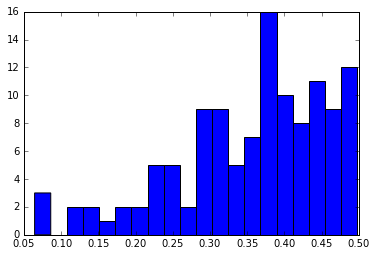

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

mu = np.average(fn_pr)
sigma = np.std(np.array(fn_pr))

print(mu, sigma)

count, bins, ignored = plt.hist(fn_pr, 20)
#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')
plt.show()

##### Napačno pozitivne napovedi

0.593005847953 0.072053085564


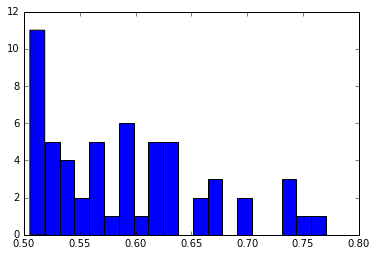

In [63]:
mu = np.average(fp_pr)
sigma = np.std(np.array(fp_pr))

print(mu, sigma)

count, bins, ignored = plt.hist(fp_pr, 20)
#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')
plt.show()

##### Napake po kategorijah

In [66]:
df = pd.read_csv('Kickstarter_2016.csv')
del df['Url'], df['BackersNum'], df['Plaged'], df['UpdatesNum'], df['CommentsNum'], df["Location"]
df.CampaignYear = df.CampaignYear.astype(str)
df.Subcategory = df.Subcategory.astype(str)

import urllib.parse
import urllib.request
import re
categories = [i for i in range(331,343)] + [51, 52, 362] + [i for i in range(21,35)]
for c in categories:
    try:
        url = 'https://www.kickstarter.com/discover/advanced?'
        values = {'category_id' : c, 'woe_id': '0', 'sort': 'end_date', 'seed' : '2431954', 'page': 1}
        data = urllib.parse.urlencode(values)
        reqUrl = url + str(data)
        req = urllib.request.Request(reqUrl)
        resp = urllib.request.urlopen(req)
        respData = resp.read()
        categoriy = re.findall(r'class="category">live (.*?) projects', str(respData))[0]
        print(categoriy, "& ", len(df[df.Subcategory == str(c)]), "&", "{:.0f}".format(subcat[str(c)]*len(indexes_n)),
      "&", "{:.2f}".format(subcat[str(c)]*len(indexes_n)/len(df[df.Subcategory == str(c)])), " \\\\")
    except Exception as e:
        continue
    

3D Printing &  15 & 0 & 0.00  \\
Apps &  172 & 23 & 0.13  \\
Camera Equipment &  11 & 0 & 0.00  \\
DIY Electronics &  16 & 4 & 0.25  \\
Fabrication Tools &  9 & 1 & 0.11  \\
Flight &  9 & 2 & 0.22  \\
Gadgets &  64 & 7 & 0.11  \\
Robots &  9 & 4 & 0.44  \\
Sound &  15 & 1 & 0.07  \\
Space Exploration &  12 & 3 & 0.25  \\
Wearables &  31 & 3 & 0.10  \\
Web &  102 & 20 & 0.20  \\
Software &  47 & 14 & 0.30  \\
Hardware &  0 & 14 & inf  \\
Makerspaces &  0 & 0 & nan  \\
Digital Art &  8 & 1 & 0.12  \\
Illustration &  60 & 4 & 0.07  \\
Painting &  38 & 3 & 0.08  \\
Performance Art &  20 & 2 & 0.10  \\
Sculpture &  12 & 1 & 0.08  \\
Crafts &  172 & 9 & 0.05  \\
Graphic Design &  25 & 5 & 0.20  \\
Product Design &  157 & 18 & 0.11  \\
Animation &  33 & 4 & 0.12  \\
Documentary &  69 & 10 & 0.14  \\
Narrative Film &  28 & 3 & 0.11  \\
Shorts &  65 & 5 & 0.08  \\
Webseries &  49 & 3 & 0.06  \\
Tabletop Games &  0 & 11 & inf  \\


## Analiza najpomembnejših atributov
Analizirali smo najpomembnejše atribute pri logistični regresiji, Random Forest in Extra Tress algoritmu.

In [8]:
lrm = LogisticRegression(**clf_lr.best_params_)
lrm.fit(X, y)

rfc = RandomForestClassifier(**clf_rf.best_params_)
rfc.fit(X, y)

forest = ExtraTreesClassifier(**clf_et.best_params_)
forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [19]:
h = headers.values
print(h)
"""h[38] = 'FbConnected'
h[39] = 'BackedPr'
h[40] = 'CreatedPr'
h[43] = 'Rewards'
h[44] = 'MinR'
h[45] = 'MaxR'
h[46] = 'Characters'
h[47] = 'PicturesNum'
h[48] = 'VideosNum' """
h1 = [x.split('_')[-1] if len(x.split('_')) > 0 else x for x in h]
h1 = np.array(h1)

['FbConnection' 'BackedProj' 'CreatedProj' 'CDescLength' 'TitleLength'
 'Goal' 'Duration' 'RewardsNum' 'MinPledgeTiers' 'MaxPledgeTiers'
 'CharactersNum' 'PucturesNum' 'VideosNum' 'HasVideo' 'CampaignYear_2014'
 'CampaignYear_2015' 'CampaignYear_2016' 'Month_Apr' 'Month_Aug'
 'Month_Dec' 'Month_Feb' 'Month_Jan' 'Month_Jul' 'Month_Jun' 'Month_Mar'
 'Month_May' 'Month_Nov' 'Month_Oct' 'Month_Sep' 'Subcategory_20'
 'Subcategory_21' 'Subcategory_22' 'Subcategory_23' 'Subcategory_24'
 'Subcategory_25' 'Subcategory_26' 'Subcategory_27' 'Subcategory_28'
 'Subcategory_29' 'Subcategory_30' 'Subcategory_31' 'Subcategory_32'
 'Subcategory_33' 'Subcategory_331' 'Subcategory_332' 'Subcategory_333'
 'Subcategory_334' 'Subcategory_335' 'Subcategory_336' 'Subcategory_337'
 'Subcategory_338' 'Subcategory_339' 'Subcategory_34' 'Subcategory_340'
 'Subcategory_341' 'Subcategory_342' 'Subcategory_362' 'Subcategory_51'
 'Subcategory_52']


In [16]:
print("Logistična regresija")
a = np.array(lrm.coef_[0])
indx = []
for j in range(1,20):
    imax = mx = 0
    for i, fi in enumerate(a):
        if i not in indx:
            if abs(a[i]) > abs(mx):
                imax, mx = i, a[i]
    print(headers[imax], " & ", "{:.2f}".format(mx), "\\\\")
    indx.append(imax)
    
j = 0

Logistična regresija
Goal  &  -23.40 \\
BackedProj  &  0.74 \\
PucturesNum  &  0.51 \\
Subcategory_332  &  -0.45 \\
RewardsNum  &  0.45 \\
Subcategory_32  &  0.41 \\
Subcategory_34  &  0.38 \\
Subcategory_342  &  -0.36 \\
MinPledgeTiers  &  -0.35 \\
HasVideo  &  0.35 \\
Subcategory_28  &  0.29 \\
CharactersNum  &  0.28 \\
Duration  &  -0.27 \\
Subcategory_30  &  0.25 \\
Subcategory_51  &  -0.23 \\
CampaignYear_2014  &  0.15 \\
CampaignYear_2015  &  -0.12 \\
Subcategory_22  &  0.11 \\
Month_Oct  &  -0.09 \\
Subcategory_26  &  0.09 \\
Subcategory_29  &  -0.08 \\
Subcategory_337  &  -0.08 \\
Month_Jan  &  0.07 \\
Month_Aug  &  -0.07 \\
Month_Feb  &  0.06 \\
Subcategory_52  &  -0.06 \\
Subcategory_31  &  0.06 \\
Month_Apr  &  0.06 \\
Subcategory_336  &  -0.05 \\
Subcategory_340  &  0.05 \\
MaxPledgeTiers  &  -0.05 \\
Subcategory_24  &  0.04 \\
CampaignYear_2016  &  -0.04 \\
Month_Sep  &  -0.04 \\
Month_Nov  &  -0.04 \\
VideosNum  &  -0.04 \\
TitleLength  &  0.03 \\
Subcategory_21  &  -0.03

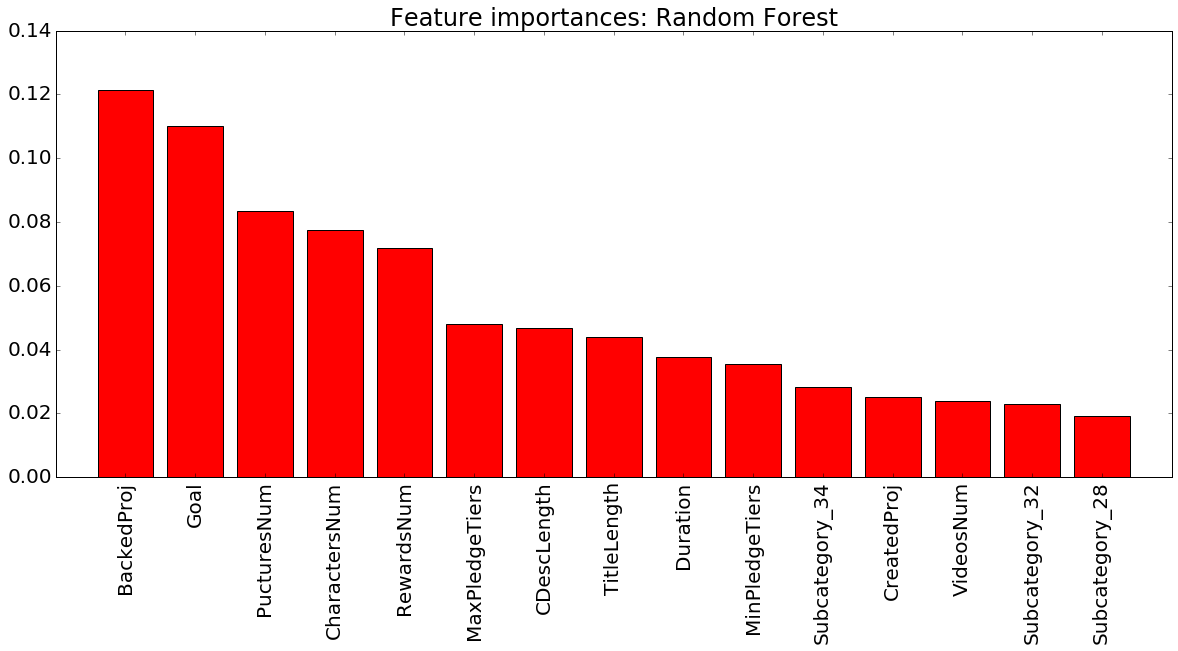

In [23]:
best = 44
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)
matplotlib.rcParams.update({'font.size': 20})
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances: Random Forest")
plt.bar(range(X.shape[1] - best), importances[indices[:-best]],
       color="r", align="center")
plt.xticks(range(X.shape[1]), h[indices[:-best]], rotation='vertical')
plt.xlim([-1, X.shape[1] - best])
plt.show()

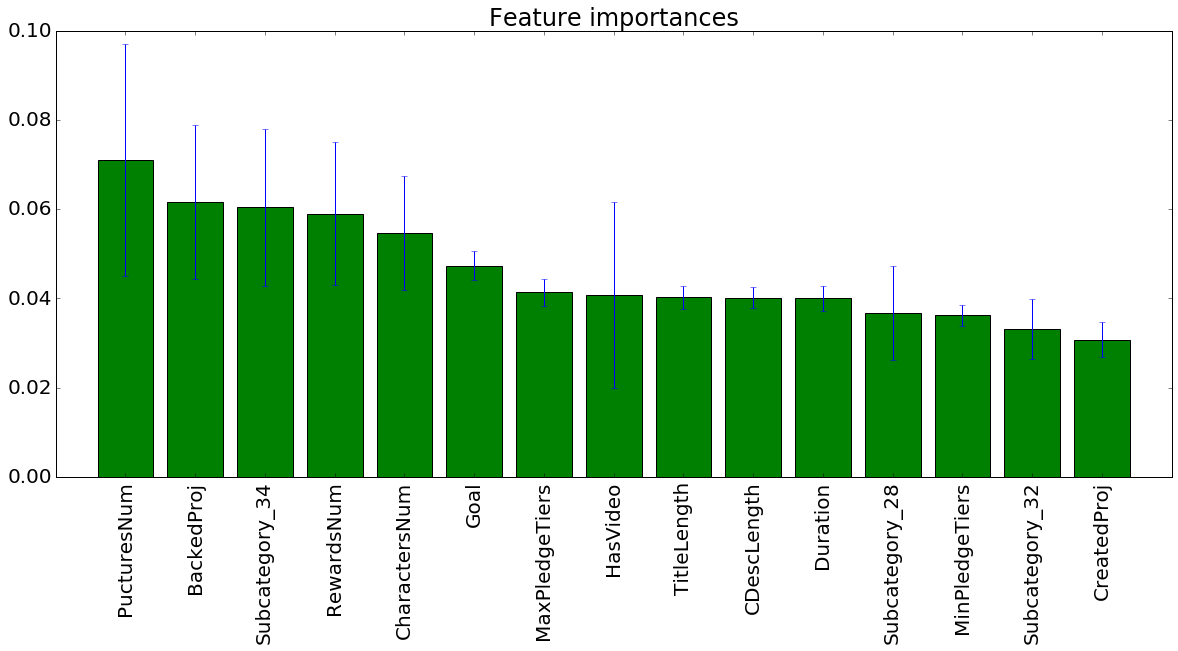

In [24]:
# Build a forest and compute the feature importances
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")
#for f in range(X.shape[1]):
#    print("%d. %s (%f)" % (f + 1, header[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1] - best), importances[indices[:-best]],
       color="g", yerr=std[indices[:-best]], align="center")
plt.xticks(range(X.shape[1]), h[indices[:-best]], rotation='vertical')
plt.xlim([-1, X.shape[1] - best])
plt.show()